# Using Machine Learning to Forecast Air Quality in Beijing

## 2 - Exploratory Data Analysis

### Import Python Packages

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import calendar
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive, drift, mean, seasonal_naive)

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
plt.style.use('fivethirtyeight')

### Load cleaned data set

In [3]:
df = pd.read_csv('data/dailypm25.csv',
                 index_col=0,
                 parse_dates=[0],
                 date_parser=pd.to_datetime,
                 infer_datetime_format=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2190 entries, 2010-01-02 to 2015-12-31
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wind_dir           2190 non-null   object 
 1   year               2190 non-null   int64  
 2   month              2190 non-null   int64  
 3   season             2190 non-null   int64  
 4   pm25               2190 non-null   float64
 5   dew_point          2190 non-null   float64
 6   humidity           2190 non-null   float64
 7   pressure           2190 non-null   float64
 8   temp               2190 non-null   float64
 9   wind_speed         2190 non-null   float64
 10  precipitation      2190 non-null   float64
 11  cum_precipitation  2190 non-null   float64
dtypes: float64(8), int64(3), object(1)
memory usage: 222.4+ KB


### Visualize daily PM2.5 over entire time span

Text(0.5, 1.0, 'Air Quality, 2010-2015')

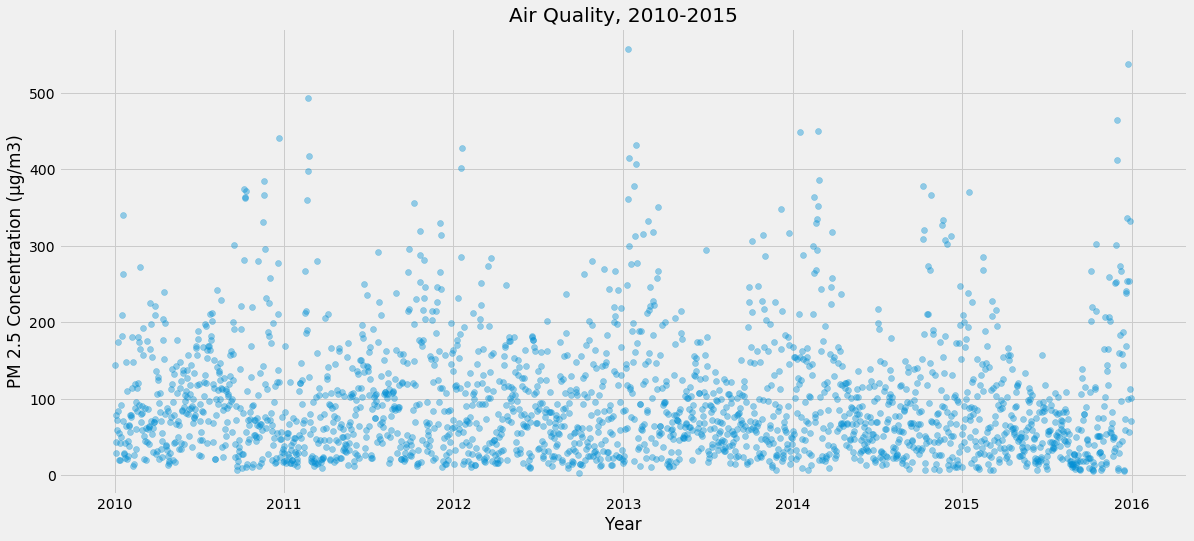

In [5]:
# Generate a simple scatter plot of daily mean PM2.5 concentration for entire time span
scatter_y = df.pm25.resample('D').mean()
scatter_x = df.pm25.resample('D').mean().index
#color = scatter_y

plt.scatter(x = scatter_x, y = scatter_y, alpha = 0.4)
plt.xlabel('Year')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality, 2010-2015')

### Visualize distribution of PM2.5

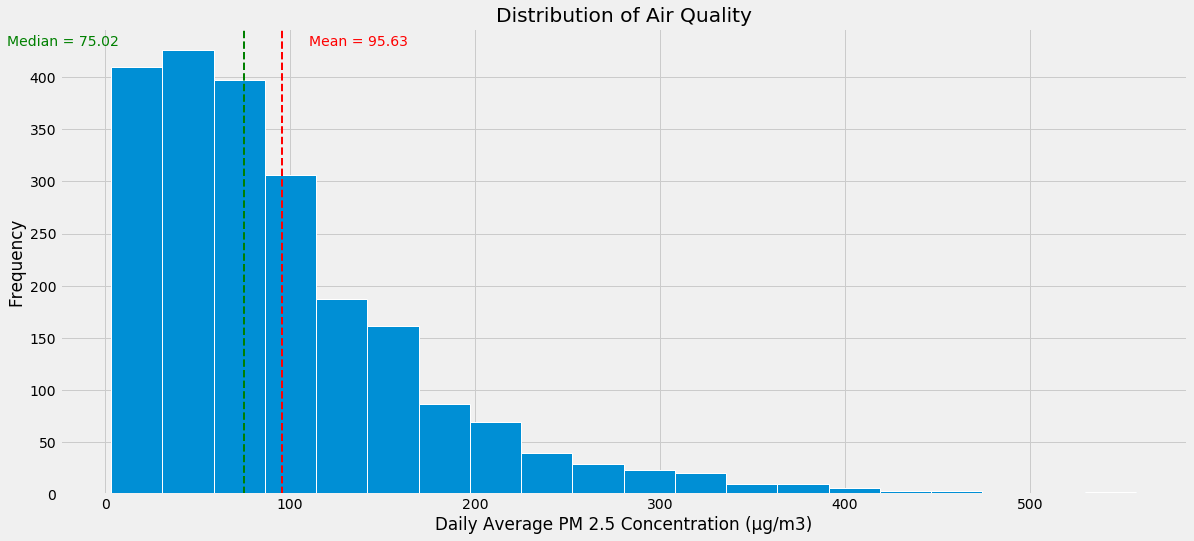

In [6]:
# Distribution of air quality for the period 2010-2015
plt.figure()
plt.hist(scatter_y.dropna(), bins = 20, edgecolor='w', lw=1)
plt.xlabel('Daily Average PM 2.5 Concentration (μg/m3)')
plt.ylabel('Frequency')
plt.title('Distribution of Air Quality')
plt.text(110, 430, 'Mean = ' + str(round(scatter_y.dropna().mean(),2)), color = 'red')
plt.text(-53, 430, 'Median = ' + str(round(scatter_y.dropna().median(),2)), color = 'green')
plt.axvline(scatter_y.dropna().mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(scatter_y.dropna().median(), color='g', linestyle='dashed', linewidth=2)

### Visualize proportion of days characterized by each PM2.5 classification

Text(0.5, 1.0, 'Percentage of Days Within Each Air Quality Classification')

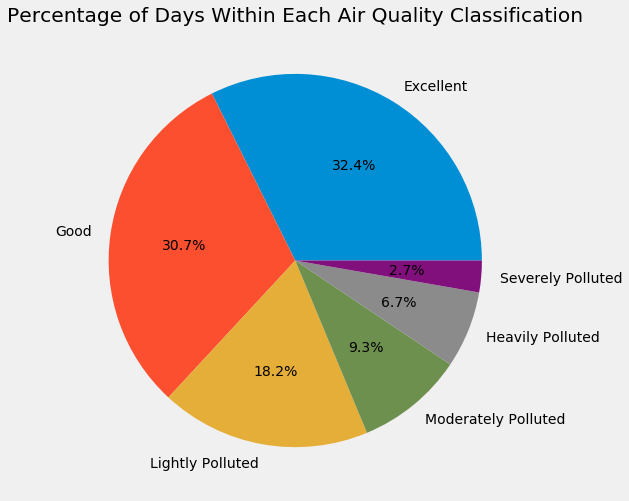

In [7]:
# Generate a pie chart to show portion of days falling into each air quality classification
excellent = len([ii for ii in scatter_y.dropna() if ii <= 50])
good = len([ii for ii in scatter_y.dropna() if ii > 50 and ii <= 100])
lightly = len([ii for ii in scatter_y.dropna() if ii > 100 and ii <= 150])
moderately = len([ii for ii in scatter_y.dropna() if ii > 150 and ii <= 200])
heavily = len([ii for ii in scatter_y.dropna() if ii > 200 and ii <= 300])
severely = len([ii for ii in scatter_y.dropna() if ii > 300])
sizes = [excellent, good, lightly, moderately, heavily, severely]
labels = ['Excellent','Good','Lightly Polluted','Moderately Polluted','Heavily Polluted','Severely Polluted']
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Percentage of Days Within Each Air Quality Classification')

### Visualize PM2.5 by month

([<matplotlib.axis.XTick at 0x7f1b06d17390>,
 <a list of 12 Text xticklabel objects>)

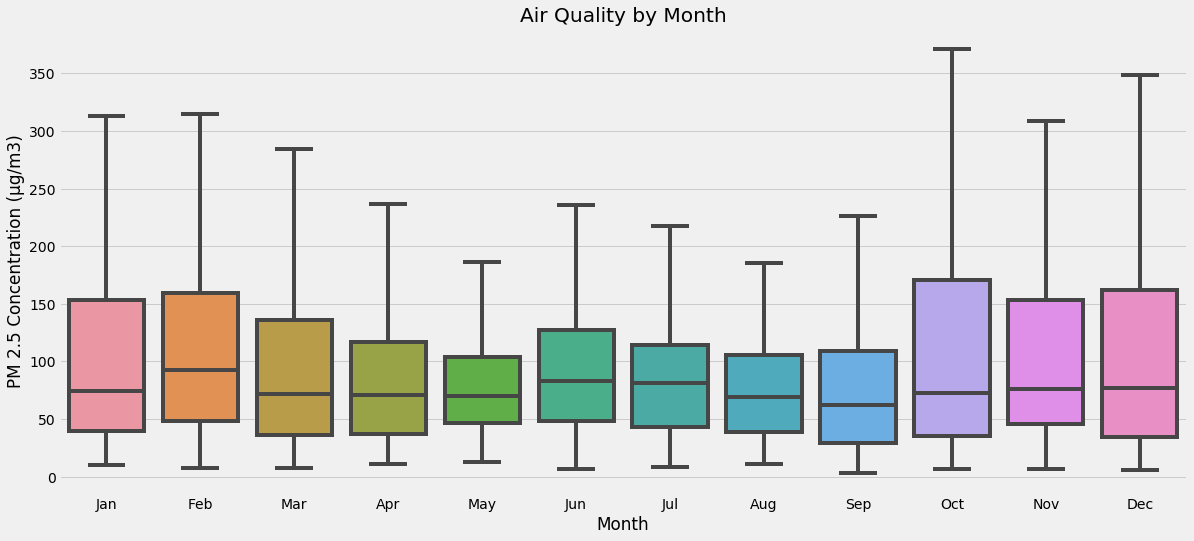

In [8]:
# Plot PM 2.5 level by MONTH
plt.figure()
sns.boxplot(x="month", y="pm25", data=df, showfliers=False)
plt.xlabel('Month')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Month')
plt.xticks(range(0,12), calendar.month_abbr[1:13])

### Visualize PM2.5 by day of the week

([<matplotlib.axis.XTick at 0x7f1b015edd50>,
 <a list of 7 Text xticklabel objects>)

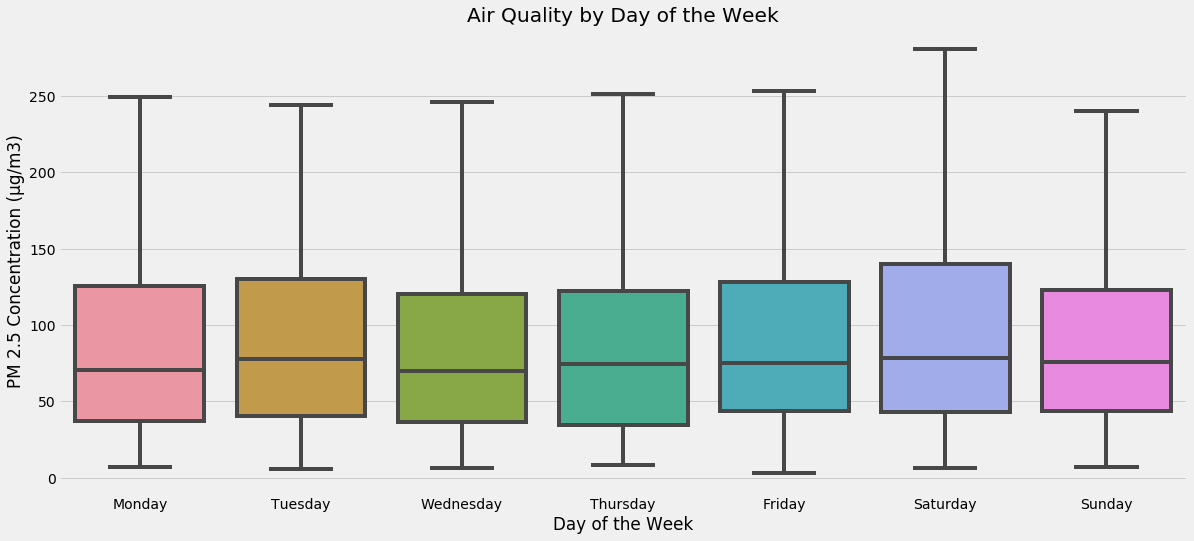

In [15]:
# Plot PM 2.5 level by DAY OF THE WEEK
df_length = df.shape[0]

weekday = []

for ii in list(range(df_length)):
    weekday.append(calendar.weekday(df.year[ii],
        df.month[ii], df.index.day[ii]))
    
df['weekday'] = weekday

plt.figure()
sns.boxplot(x="weekday", y="pm25", data=df, showfliers=False)
plt.xlabel('Day of the Week')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Day of the Week')
plt.xticks(range(0,7), calendar.day_name)

### Visualize PM2.5 by hour of the day

### Perform univariate analysis for all weather features 

Text(0.5, 1.0, 'Air Quality vs. Temperature')

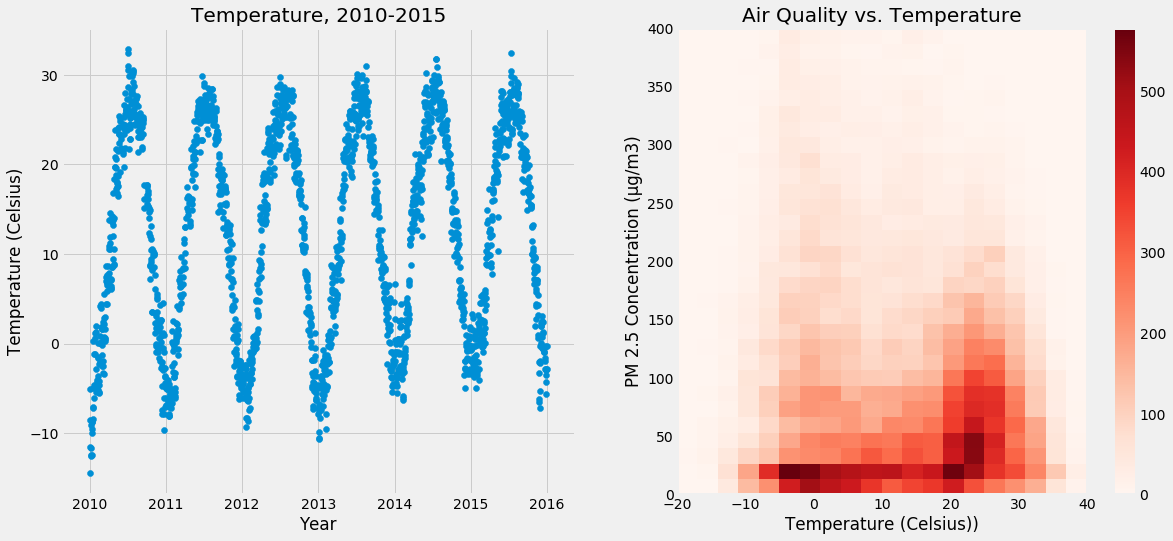

In [ ]:
# Now we take a look at the other features apart from air concentration:

# Temperature

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.temp.resample('D').mean().index, y = df.temp.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Temperature (Celsius)')
plt.title('Temperature, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.temp, y = df.pm25, bins = (20, 30), range = ((-20,40),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Temperature (Celsius))')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Temperature')

Text(0.5, 1.0, 'Air Quality vs. Pressure')

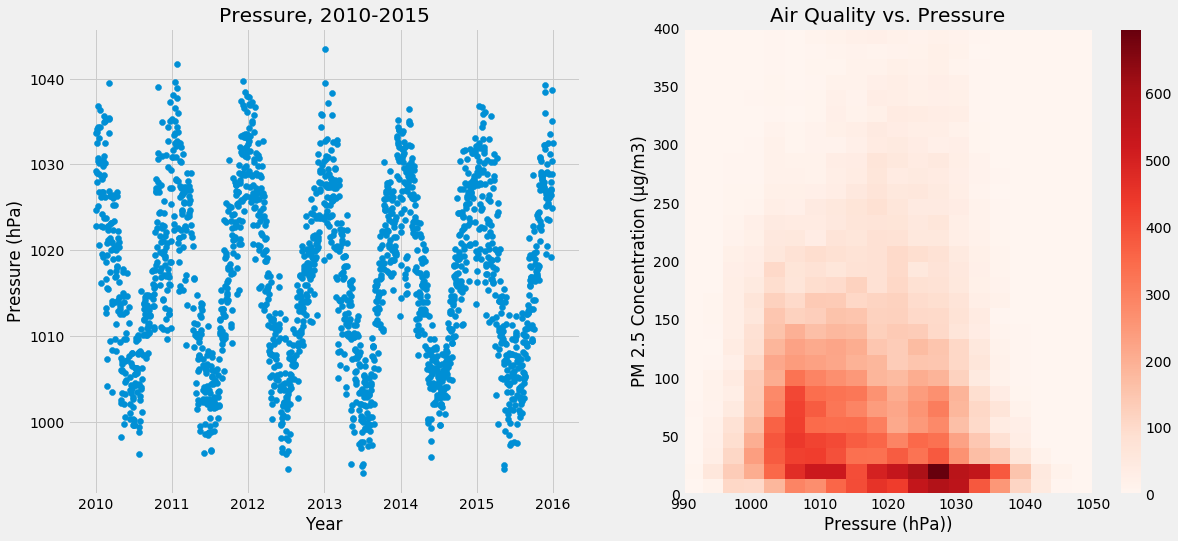

In [ ]:
# Pressure

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.pressure.resample('D').mean().index, y = df.pressure.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Pressure (hPa)')
plt.title('Pressure, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.pressure, y = df.pm25, bins = (20, 30), range = ((990,1050),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Pressure (hPa))')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Pressure')

Text(0.5, 1.0, 'Air Quality vs. Humidity')

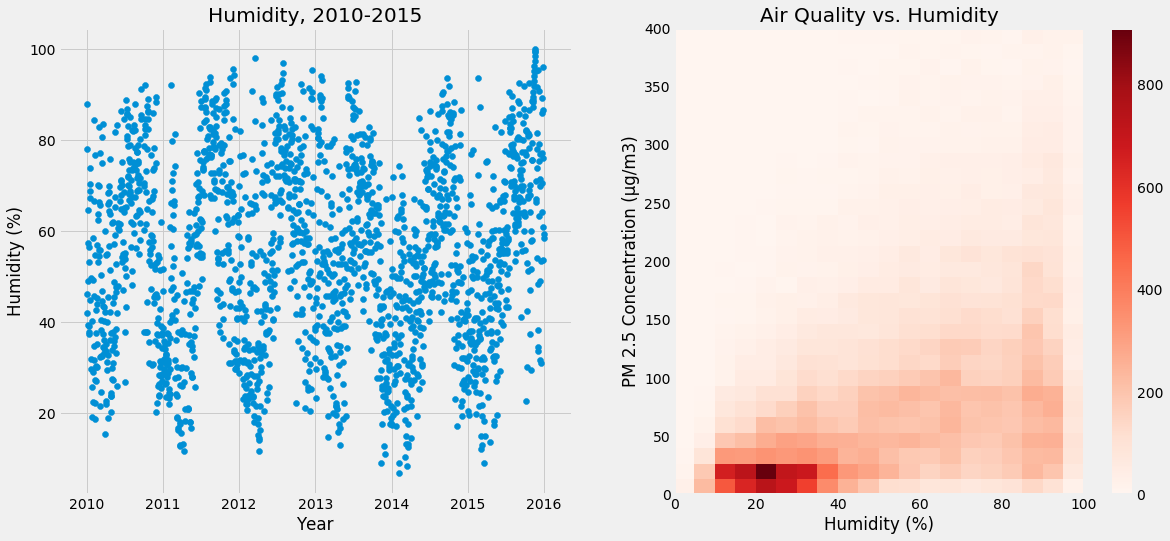

In [ ]:
# Humidity

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.humidity.resample('D').mean().index, y = df.humidity.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Humidity (%)')
plt.title('Humidity, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.humidity, y = df.pm25, bins = (20, 30), range = ((0,100),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Humidity (%)')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Humidity')

Text(0.5, 1.0, 'Air Quality vs. Dew Point')

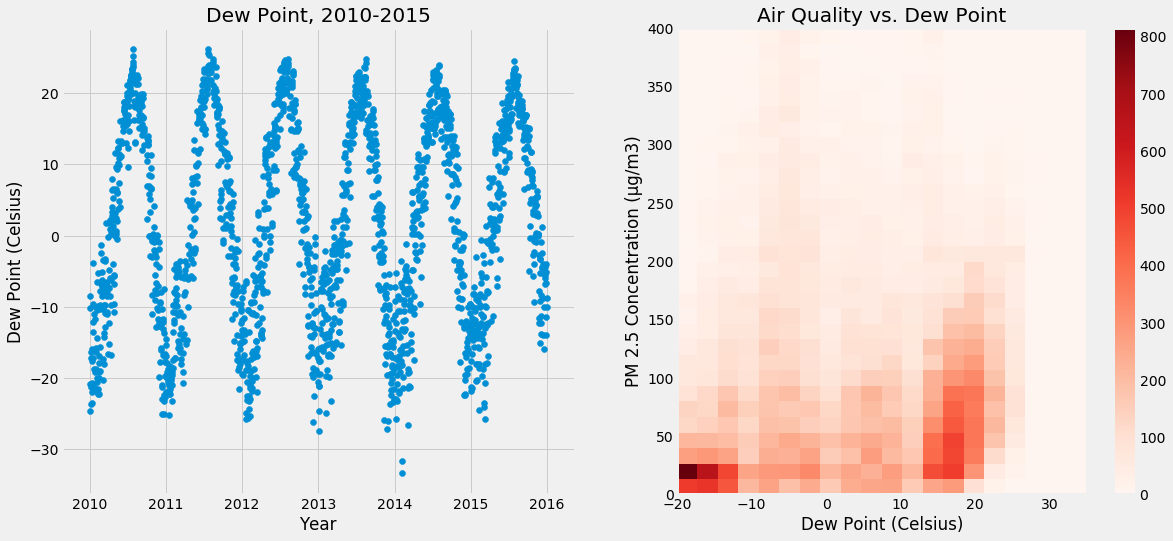

In [ ]:
# Dew Point

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.dew_point.resample('D').mean().index, y = df.dew_point.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Dew Point (Celsius)')
plt.title('Dew Point, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.dew_point, y = df.pm25, bins = (20, 30), range = ((-20,35),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Dew Point (Celsius)')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Dew Point')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


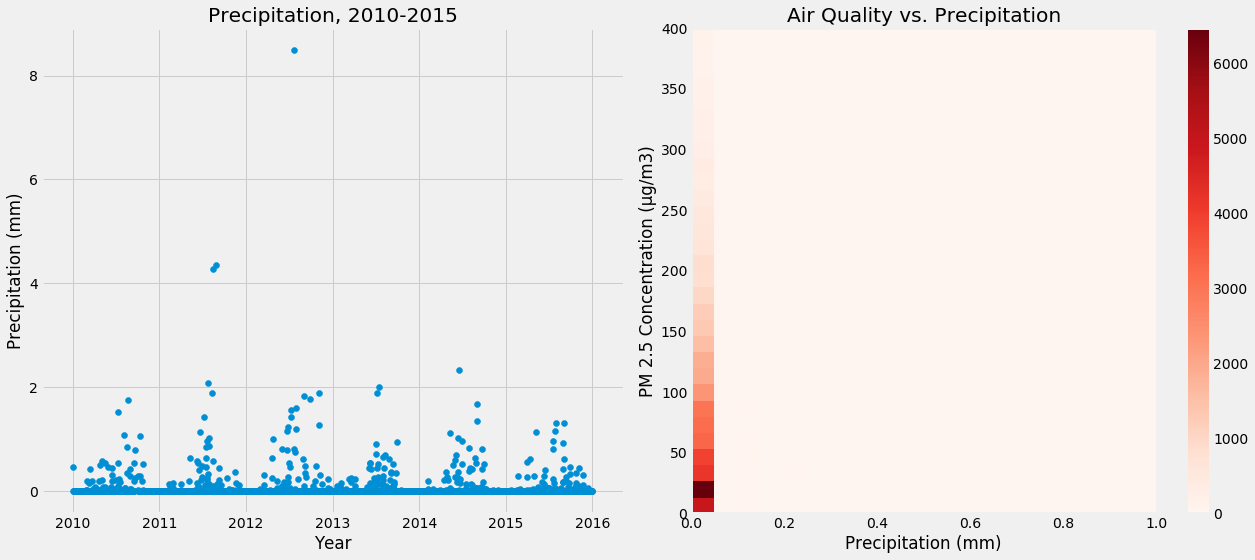

In [ ]:
# Precipitation

df.precipitation[df.precipitation >= 1000] = np.nan  # Remove erroneous 999990.0 point

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.precipitation.resample('D').mean().index, y = df.precipitation.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.title('Precipitation, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.precipitation, y = df.pm25,
           bins = (20, 30), range = ((0,1),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Precipitation (mm)')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Precipitation')
plt.tight_layout()

### STL Decomposition

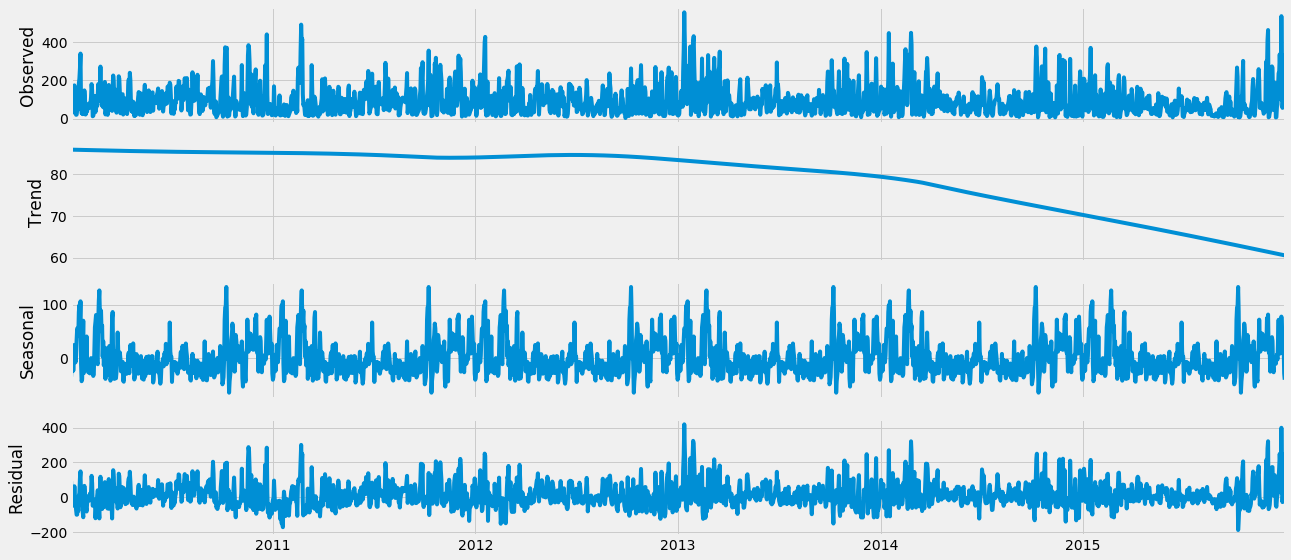

In [19]:
decomp = decompose(df.pm25, period=365)
decomp.plot();